### Part I: Hybrid Images

In [1]:
import cv2
import numpy as np
from matplotlib.colors import LogNorm
from scipy import signal

import utils

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
im1_file = './Dog.jpg'
im2_file = './Horse.jpg'

im1 = cv2.imread(im1_file, cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread(im2_file, cv2.IMREAD_GRAYSCALE)

In [4]:
def filter_image(im, fil):
    '''
    Inputs:
        im: A grayscale image or one channel of a color image as a numpy array
        fil: M x M floating point numpy ndarray representing 2D filter
        
    Output:
        Returns the filtered image
    '''
    H, W = im.shape
    hs = fil.shape[0] // 2  # half size of the filter
    fftsize_H = H + hs if H + hs % 2 else H + hs + 1   # height of the fft + padding. fft size is power of 2.
    fftsize_W = W + hs if W + hs % 2 else W + hs + 1   # width of the fft + padding. fft size is power of 2.
    im_fft = np.fft.fft2(im, (fftsize_H, fftsize_W))   # compute fft of image with padding
    fil_fft = np.fft.fft2(fil, (fftsize_H, fftsize_W)) # compute fft of filter padded to same size as the image
    im_fil_fft = im_fft * fil_fft                      # pointwise multiply elements of filter fft and image fft together
    im_fil = np.fft.ifft2(im_fil_fft)                  # compute inverse fft
    im_fil = im_fil[hs:hs + H, hs:hs + W]              # remove padding
    im_fil = np.real(im_fil)                           # extract real part
    return im_fil

In [5]:
def hybrid(im1, im2, sigma_high, sigma_low):
    '''
    Imputs:
        im1: A grayscale image or one channel of a color image as a numpy array
        im2: A grayscale image or one channel of a color image as a numpy array
        sigma_low: Standard deviation for low-pass filter
        sigma_high: Standard deviation for high-pass filter
    
    Outputs:
        Returns a tuple containing the hybrid image, i.e., blend of high-pass filtered image 1 and low-pass
        filtered image 2, an image containing the high frequency components of im1, and an image containing
        the low frequency components of im2
    '''
    # Create Gaussian kernels to filter the images with
    G_high = utils.gaussian_kernel(sigma_high, 3 * sigma_high)
    G_low = utils.gaussian_kernel(sigma_low, 3 * sigma_low)

    # high-pass filter image 1 by subtracting gaussian filterd image from the original image
    im1_fil = im1 - filter_image(im1, G_high)

    # low-pass filter image 2
    im2_fil = filter_image(im2, G_low)
    
    im_hybrid = im1_fil + im2_fil
    
    # blend images to create a hybrid image
    return im_hybrid, im1_fil, im2_fil

In [6]:
def display_image_and_fft(im):
    '''
    Input:
        im: an RGB or grayscale image
    Outputs:
        Displays image and log magnitude of FFT of image
    '''
    fig, axs = plt.subplots(1, 2)

    axs[0].set_title('Image'), axs[0].set_xticks([]), axs[0].set_yticks([])
    axs[0].imshow(im,cmap='gray')

    axs[1].set_title('Log FFT Magnitude of Image'), axs[1].set_xticks([]), axs[1].set_yticks([])
    ax10 = axs[1].imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(im)))), cmap='jet')
    fig.colorbar(ax10, ax=axs[1])

In [7]:
display_image_and_fft(im1)

<IPython.core.display.Javascript object>

In [8]:
display_image_and_fft(im2)

<IPython.core.display.Javascript object>

In [9]:
pts_im1 = utils.prompt_eye_selection(im1)

<IPython.core.display.Javascript object>

In [10]:
pts_im2 = utils.prompt_eye_selection(im2)

<IPython.core.display.Javascript object>

In [11]:
im1, im2 = utils.align_images(im1_file, im2_file, pts_im1, pts_im2, save_images=False)

In [12]:
# convert to grayscale
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY) / 255.0
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY) / 255.0

In [13]:
# Choose standard deviation for high-pass and low-pass filters
sigma_high = 40
sigma_low = 40

im_hybrid = hybrid(im1, im2, sigma_high, sigma_low)

<IPython.core.display.Javascript object>


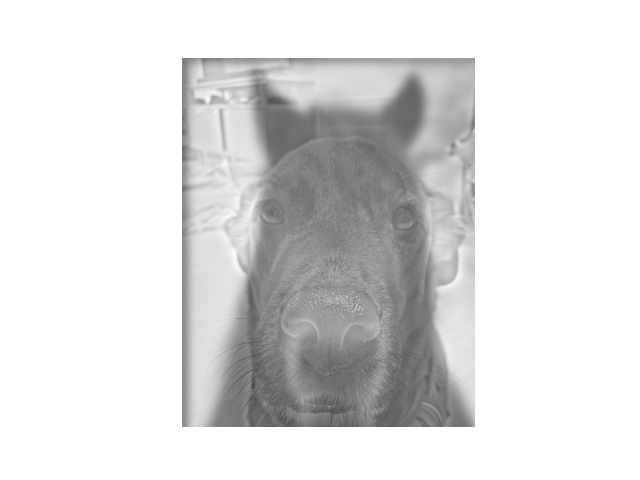

In [14]:
# Optional: Select top left corner and bottom right corner to crop image
# the function returns dictionary of 
# {
#   'cropped_image': np.ndarray of shape H x W
#   'crop_bound': np.ndarray of shape 2x2
# }
cropped_object = utils.interactive_crop(im_hybrid[0])

In [15]:
display_image_and_fft(im_hybrid[1])

<IPython.core.display.Javascript object>

In [16]:
display_image_and_fft(im_hybrid[2])

<IPython.core.display.Javascript object>

In [17]:
display_image_and_fft(im_hybrid[0])

<IPython.core.display.Javascript object>


<b>Gaussian and Laplacian pyramids of hybrid image</b>

In [88]:
im_pyr = cv2.imread('Greg_hybrid.jpg', cv2.IMREAD_GRAYSCALE)

In [89]:
# Create Gaussian kernel
sigma_pyr = 3
ksize_pyr = np.int(np.ceil(sigma_pyr) * 6 + 1)
G_pyr = cv2.getGaussianKernel(ksize_pyr, sigma_pyr)
G_pyr = G_pyr * np.transpose(G_pyr)

<IPython.core.display.Javascript object>


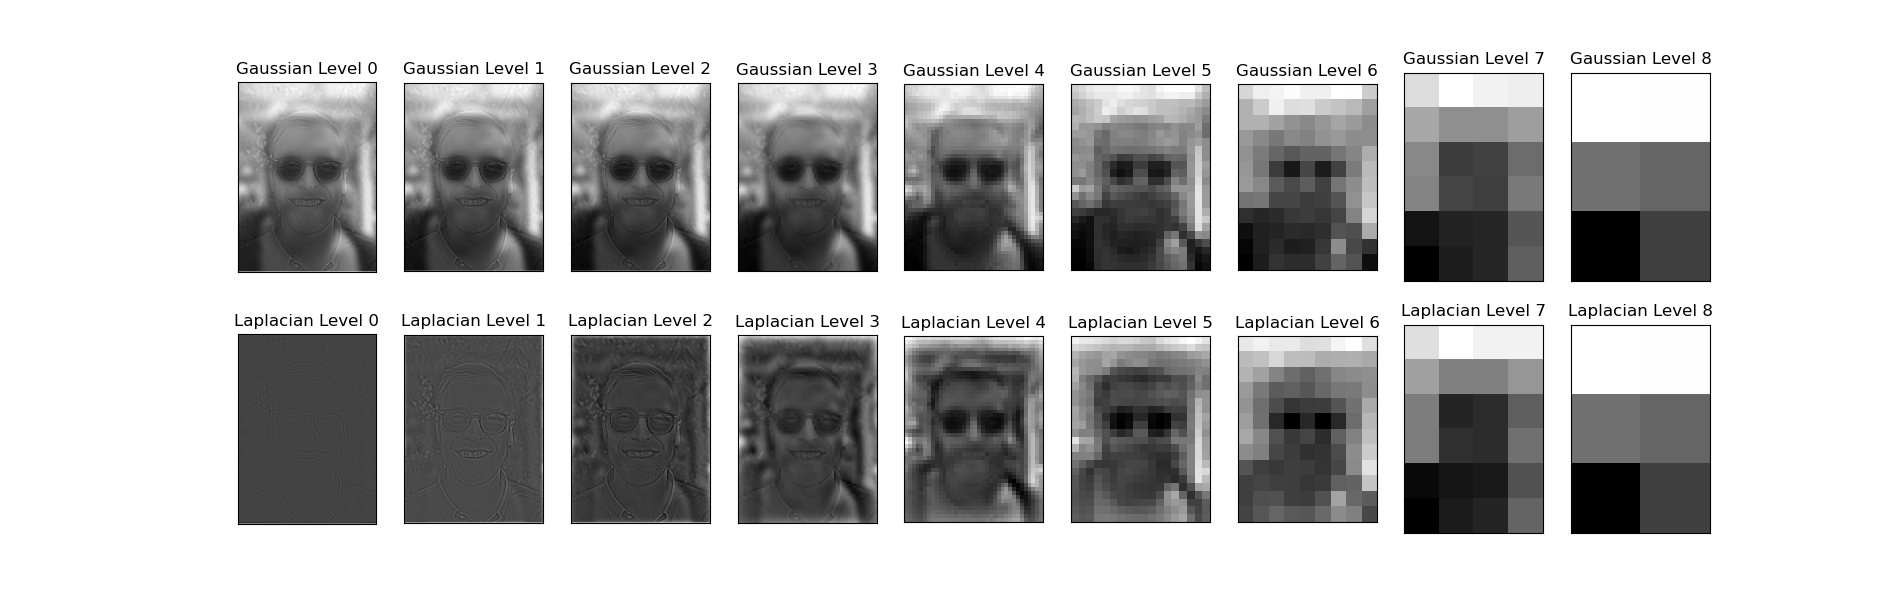

In [90]:
fig, axs = plt.subplots(2, 9, figsize=(19, 6))

axs[0, 0].set_title('Gaussian Level 0'), axs[0, 0].set_xticks([]), axs[0, 0].set_yticks([])
axs[0, 0].imshow(im_pyr, cmap='gray')

for i in range(1, 9):
    
    # smooth image
    im_smooth = filter_image(im_pyr, G_pyr)
    
    # Compute Laplacian
    im_lap = im_pyr - im_smooth
    
    # downsample image
    im_pyr = cv2.resize(im_pyr, None, fx=0.5, fy = 0.5)
    
    axs[0, i].set_title('Gaussian Level {}'.format(i)), axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[0, i].imshow(im_pyr, cmap='gray')
    
    axs[1, i - 1].set_title('Laplacian Level {}'.format(i - 1)), axs[1, i - 1].set_xticks([]), axs[1, i - 1].set_yticks([])
    axs[1, i - 1].imshow(im_lap, cmap='gray')

axs[1, 8].set_title('Laplacian Level 8'), axs[1, 8].set_xticks([]), axs[1, 8].set_yticks([])
axs[1, 8].imshow(im_pyr, cmap='gray')


<b>Color Hybrid Images</b>

In [19]:
im1_file = 'Jaguar.jpg'
im2_file = 'Cat.jpg'

im1_bgr = cv2.imread(im1_file)
im2_bgr = cv2.imread(im2_file)

In [20]:
im1_rgb = cv2.cvtColor(im1_bgr, cv2.COLOR_BGR2RGB)
im2_rgb = cv2.cvtColor(im2_bgr, cv2.COLOR_BGR2RGB)

<IPython.core.display.Javascript object>


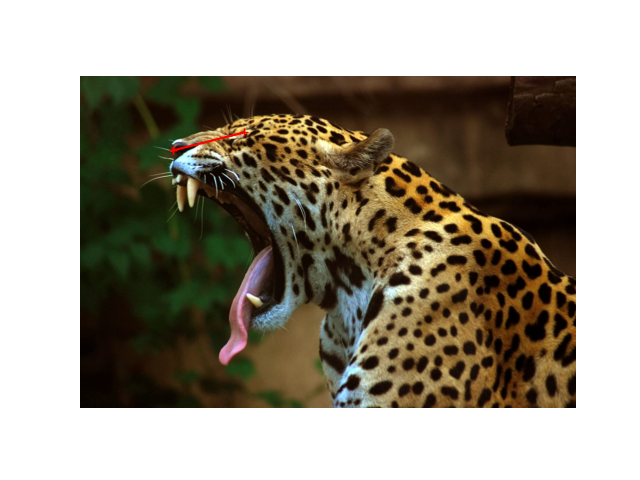

In [21]:
pts_im1 = utils.prompt_eye_selection(im1_rgb)

<IPython.core.display.Javascript object>


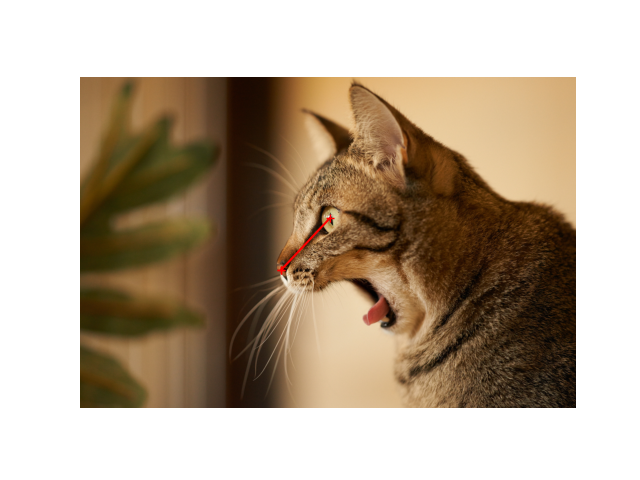

In [22]:
pts_im2 = utils.prompt_eye_selection(im2_rgb)

In [26]:
im1_bgr, im2_bgr = utils.align_images(im1_file, im2_file, pts_im1, pts_im2, save_images=False)

In [27]:
im1_rgb = cv2.cvtColor(im1_bgr, cv2.COLOR_BGR2RGB) / 255
im2_rgb = cv2.cvtColor(im2_bgr, cv2.COLOR_BGR2RGB) / 255

In [28]:
# Choose standard deviation for high-pass and low-pass filters
sigma_high = 6
sigma_low = 15

In [29]:
# Compute hybrid of each channel
im_hybrid_r = hybrid(im1_rgb[:, :, 0], im2_rgb[:, :, 0], sigma_high, sigma_low)[0]
im_hybrid_g = hybrid(im1_rgb[:, :, 1], im2_rgb[:, :, 1], sigma_high, sigma_low)[0]
im_hybrid_b = hybrid(im1_rgb[:, :, 2], im2_rgb[:, :, 2], sigma_high, sigma_low)[0]


# merge channels
im_hybrid = cv2.merge([im_hybrid_r, im_hybrid_g, im_hybrid_b])

<IPython.core.display.Javascript object>


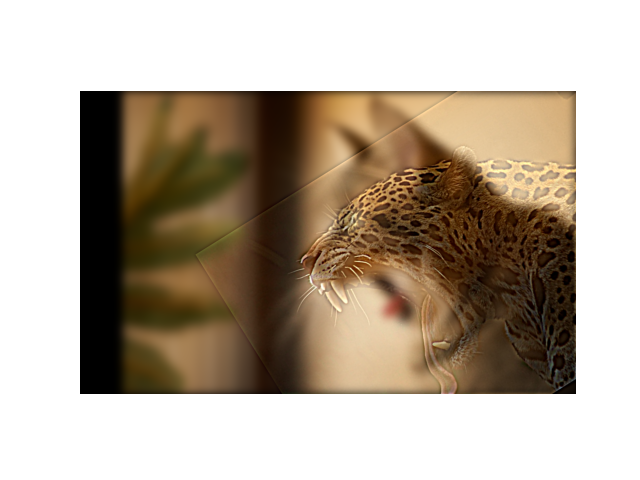

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [30]:
# Optional: Select top left corner and bottom right corner to crop image
# the function returns dictionary of 
# {
#   'cropped_image': np.ndarray of shape H x W
#   'crop_bound': np.ndarray of shape 2x2
# }
cropped_object = utils.interactive_crop(im_hybrid)

In [31]:
# convert images to grayscale to test mixing grayscale and color
im1_gray = cv2.cvtColor(im1_bgr, cv2.COLOR_BGR2GRAY) / 255.0
im2_gray = cv2.cvtColor(im2_bgr, cv2.COLOR_BGR2GRAY) / 255.0

In [32]:
# Compute hybrid of each channel, with image one in grayscale
im_hybrid_r = hybrid(im1_gray, im2_rgb[:, :, 0], sigma_high, sigma_low)[0]
im_hybrid_g = hybrid(im1_gray, im2_rgb[:, :, 1], sigma_high, sigma_low)[0]
im_hybrid_b = hybrid(im1_gray, im2_rgb[:, :, 2], sigma_high, sigma_low)[0]

# merge channels
im_hybrid = cv2.merge([im_hybrid_r, im_hybrid_g, im_hybrid_b])

<IPython.core.display.Javascript object>


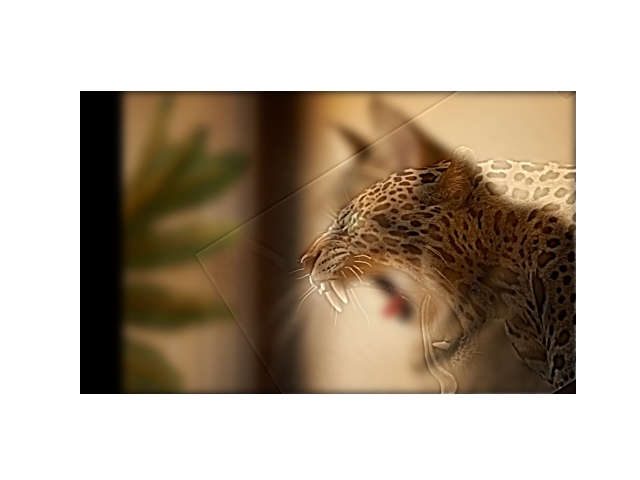

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [33]:
# Optional: Select top left corner and bottom right corner to crop image
# the function returns dictionary of 
# {
#   'cropped_image': np.ndarray of shape H x W
#   'crop_bound': np.ndarray of shape 2x2
# }
cropped_object = utils.interactive_crop(im_hybrid)

In [34]:
# Compute hybrid of each channel, with image 2 in grayscale
im_hybrid_r = hybrid(im1_rgb[:, :, 0], im2_gray, sigma_high, sigma_low)[0]
im_hybrid_g = hybrid(im1_rgb[:, :, 1], im2_gray, sigma_high, sigma_low)[0]
im_hybrid_b = hybrid(im1_rgb[:, :, 2], im2_gray, sigma_high, sigma_low)[0]

# merge channels
im_hybrid = cv2.merge([im_hybrid_r, im_hybrid_g, im_hybrid_b])

<IPython.core.display.Javascript object>


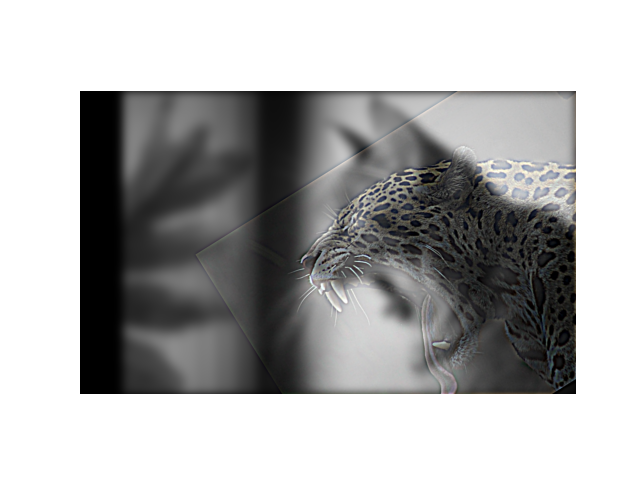

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [35]:
# Optional: Select top left corner and bottom right corner to crop image
# the function returns dictionary of 
# {
#   'cropped_image': np.ndarray of shape H x W
#   'crop_bound': np.ndarray of shape 2x2
# }
cropped_object = utils.interactive_crop(im_hybrid)

### Part II: Image Enhancement

##### Two out of three types of image enhancement are required.  Choose a good image to showcase each type and implement a method.  This code doesn't rely on the hybrid image part.

#### Contrast enhancement

In [1]:
import cv2
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
# read image as bgr, convert to hsv, and split hsv into hue, saturation, and value channels
im_bgr = cv2.imread('./shanghai_night.jpg', cv2.IMREAD_COLOR)
im_hsv = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2HSV)
hue, sat, val = cv2.split(im_hsv)

In [3]:
# perform global histogram equalization on the value channel
val_hist_eq = cv2.equalizeHist(val)

# merge back into HSV and convert to RGB
im_hist_eq_rgb = cv2.cvtColor(cv2.merge([hue, sat, val_hist_eq]), cv2.COLOR_HSV2RGB)

In [22]:
alpha = 0.5
val_blend = np.array(((val * (1 - alpha)) + (val_hist_eq * alpha)), dtype='uint8')

# merge back into HSV and convert to RGB
im_blend_rgb = cv2.cvtColor(cv2.merge([hue, sat, val_blend]), cv2.COLOR_HSV2RGB)

In [28]:
# perform contrast limited adaptive histogram equalization on the value channel
clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
val_ahist_eq = clahe.apply(val)

# merge back into HSV and convert to RGB
im_ahist_eq_rgb = cv2.cvtColor(cv2.merge([hue, sat, val_ahist_eq]), cv2.COLOR_HSV2RGB)

<IPython.core.display.Javascript object>


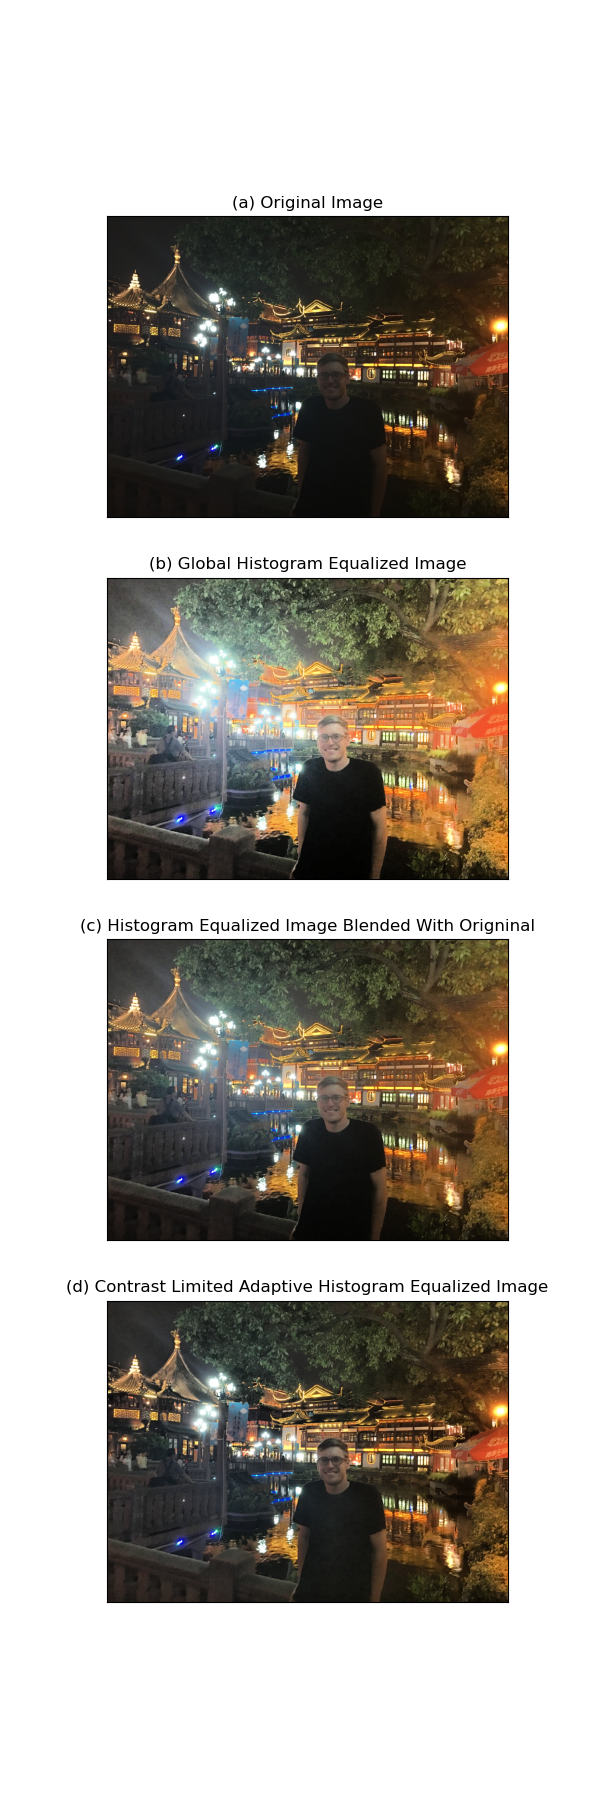

In [41]:
# display origonal and enhanced images
fig, axs = plt.subplots(4, 1, figsize=(6, 18))

axs[0].set_title('(a) Original Image'), axs[0].set_xticks([]), axs[0].set_yticks([])
axs[0].imshow(cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB))

axs[1].set_title('(b) Global Histogram Equalized Image'), axs[1].set_xticks([]), axs[1].set_yticks([])
axs[1].imshow(im_hist_eq_rgb)

axs[2].set_title('(c) Histogram Equalized Image Blended With Origninal'), axs[2].set_xticks([]), axs[2].set_yticks([])
axs[2].imshow(im_blend_rgb)

axs[3].set_title('(d) Contrast Limited Adaptive Histogram Equalized Image'), axs[3].set_xticks([]), axs[3].set_yticks([])
axs[3].imshow(im_ahist_eq_rgb)

In [ ]:
hist = cv2.calcHist(val_hist_eq, [0], None, [256], [0, 256])
np.plot(hist)  

#### Color enhancement 

In [76]:
import cv2
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

In [77]:
im2 = cv2.imread('Mural.jpg')
im2_hsv = cv2.cvtColor(im2, cv2.COLOR_BGR2HSV)

In [78]:
# create an enhanced saturation channel by scaling the current saturation
# values from 0 - 1, performing a gamma adjustment on the scaled values, and
# scaling back to the 0 - 255 range
sat_enhanced = 255 * ((im2_hsv[:, :, 1] / 255) ** 0.5)
im2_hsv[:, :, 1] =  sat_enhanced

<IPython.core.display.Javascript object>


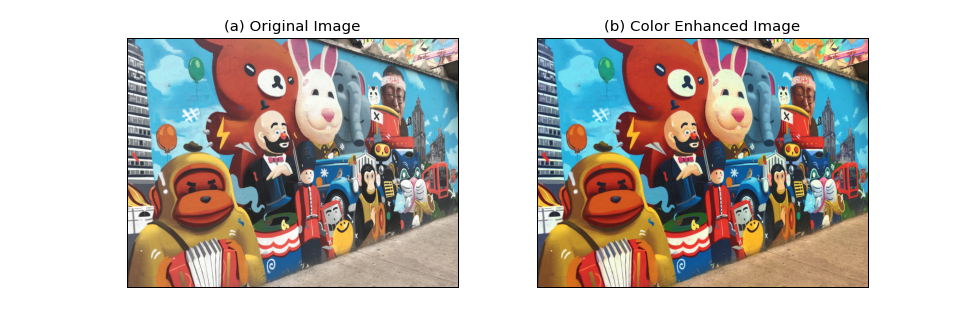

In [79]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].set_title('(a) Original Image'), axs[0].set_xticks([]), axs[0].set_yticks([])
axs[0].imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))

axs[1].set_title('(b) Color Enhanced Image'), axs[1].set_xticks([]), axs[1].set_yticks([])
axs[1].imshow(cv2.cvtColor(im2_hsv, cv2.COLOR_HSV2RGB))

#### Color shift

In [1]:
import cv2
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
im3 = cv2.imread('Library.jpg')
im3_lab = cv2.cvtColor(im3, cv2.COLOR_BGR2LAB)

In [4]:
# shift image to be more red by scaling a channel values to range 0 - 1 and gamma shifting with value less than 1
a_shift = np.array(255 * ((im3_lab[:, :, 1] / 255) ** 0.5), dtype='uint8')

# shift image to be less yellow by scaling b channel values to range 0 - 1 and gamma shifting with value greater than 1
b_shift = np.array(255 * ((im3_lab[:, :, 2] / 255) ** 1.5), dtype='uint8')

# merge the color shifted a channel with the original L and b channel and convert to RGB color space
im3_more_red_rgb = cv2.cvtColor(cv2.merge([im3[:, :, 0], a_shift, im3[:, :, 2]]), cv2.COLOR_LAB2RGB)

# merge the color shifted b channel with the original L and a channel and convert to RGB color space
im3_less_yellow_rgb = cv2.cvtColor(cv2.merge([im3[:, :, 0], im3[:, :, 1], b_shift]), cv2.COLOR_LAB2RGB)

<IPython.core.display.Javascript object>


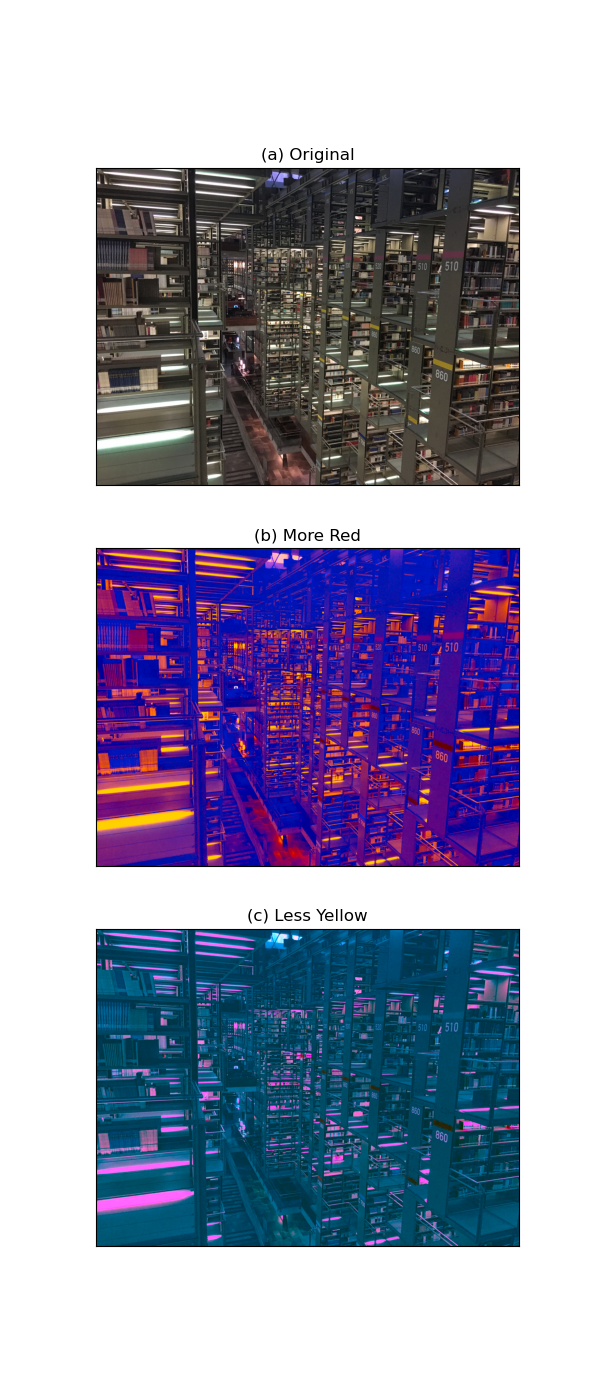

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(6,14))

axs[0].set_title('(a) Original'), axs[0].set_xticks([]), axs[0].set_yticks([])
axs[0].imshow(cv2.cvtColor(im3, cv2.COLOR_BGR2RGB))

axs[1].set_title('(b) More Red'), axs[1].set_xticks([]), axs[1].set_yticks([])
axs[1].imshow(im3_more_red_rgb)

axs[2].set_title('(c) Less Yellow'), axs[2].set_xticks([]), axs[2].set_yticks([])
axs[2].imshow(im3_less_yellow_rgb)